# Gaussian Prediction Toy Example

Theory and implementation of the gaussian action likelihood.

## 1. Generative Model

We assume that there are k points of interest, called **subgoals**, in the workspace, at which the human operator will need to have full control authority. The subgoals are drawn each cycle from a GMM with fixed components.

For instance, the offline training may yield a mixture model with 6 subgoal clusters and their respective covariance matrices. The $z^{th}$ subgoal is then:

$$\mathbf{g}_z \sim \mathcal{N}(\boldsymbol{\mu}_z, \mathbf{\Sigma}_z)$$

If state, $\mathbf{s}_i$, is known deterministically, then we can also consider a Gaussian error distribution for each subgoal:

$$\mathbf{e}_z \sim \mathcal{N}(\boldsymbol{\mu}_z - \mathbf{s}_i, \mathbf{\Sigma}_z)$$

We assert the most likely actions $\mathbf{a}_{i}$, are those which decrease the mean error.

### 1.a. Ignore Correlation

By assuming the variables are nearly uncorrelated (i.e., ignore the off diagonal elements of the covariance matrix), we can find the univariate normal cumulative density functions in each direction. There are plenty of efficient tools for computing the univariate normal cdf.

We then define the cdf's in each dimension: (this is where we lose our multivariate gaussian treatment)

\begin{equation}
F_z (s_{ij}) = \frac{1}{2} \left[ 1 + \text{erf} \left( \frac{s_{ij}-\mu_{zj}}{{\sqrt{2 \Sigma_{jj}}}} \right) \right]
\end{equation}

which is the probability that the sampled subgoal along the $j^{th}$ axis,  $\mathbf{g}_{zj}$ is less than the current state along that axis $\mathbf{s}_{ij}$.

Now we can define the action likelihood:

\begin{equation}
\Pr(a_{ij} | s_{ij}, g_z) =
\begin{cases}
        F(s_{ij}) 	&  a_{ij} < 0 \\
	1 - F(s_{ij}) 	&  a_{ij} > 0 \\
    1               &  a_{ij} = 0
\end{cases}
\end{equation}

Then we can define either the **joint likelihood** of the (assumed uncorrelated) directions:

$$\Pr(a_i | s_i, g_z) = \prod\limits_{j=1}^m \Pr(a_{ij} | s_{ij}, g_z) $$

or the **least likelihood**:

$$\Pr(a_i | s_i, g_z) = \min_j \left[ \Pr(a_{ij} | s_{ij}, g_z) \right] $$

### 1.b. Use multivariate cumulative distribution function.

The multivariate normal cumulative distribution function will be denoted

\begin{equation}
F_z (s_{ij}) = \frac{1}{2} \left[ 1 + \text{erf} \left( \frac{s_{ij}-\mu_{zj}}{{\sqrt{2 \Sigma_{jj}}}} \right) \right]
\end{equation}

## 2. Build a Test Subgoal GMM

Generate a three cluster gaussian mixtures dataset and train a GMM with scikit learn for practice.

In [4]:
%matplotlib inline

import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from scipy import linalg

In [5]:
mpl.style.use('mitch-exp')

In [6]:
#Generate some multivariate gaussian data
def gen_data():
    np.random.seed(10)
    obs = np.concatenate((1.5*np.random.randn(300, 2),
                          np.random.multivariate_normal(mean=[5, 6], cov=[[1, 0.3], [0.5, 1]], size=(100)),
                          np.random.multivariate_normal(mean=[-5, 7], cov=[[1.5, 0.7], [0.5, 0.6]], size=(100))))
    return obs

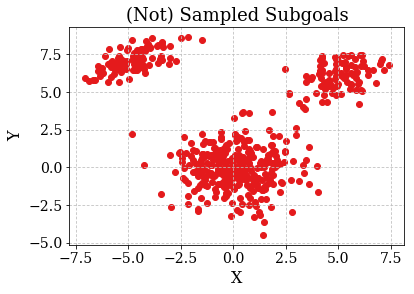

In [7]:
obser = gen_data()
plt.scatter(*np.split(obser, 2, axis=1))
plt.title('(Not) Sampled Subgoals')
plt.xlabel('X')
plt.ylabel('Y')

In [8]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, title):
    fig = plt.figure()
    ax = plt.gca()
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)

The 0'th subgoal distribution is located at [ 0.10229224 -0.06022521] with covariance [[ 2.13602159 -0.03655564]
 [-0.03655564  1.86771398]].
The 1'th subgoal distribution is located at [-4.78298662  7.08490684] with covariance [[ 1.12522456  0.50220192]
 [ 0.50220192  0.52829069]].
The 2'th subgoal distribution is located at [ 5.0089917   6.04205016] with covariance [[ 1.04874624  0.33247049]
 [ 0.33247049  0.78417994]].


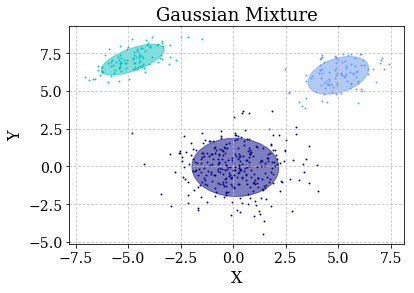

In [9]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(obser)
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Gaussian Mixture')
for i in range(3):
    print('The %i\'th subgoal distribution is located at %s with covariance %s.') % (i, gmm.means_[i], gmm.covariances_[i])

In [ ]:
gmm.covariances_[0, 0, 0]

## Test Cases

Pick random states and actions and display the action likelihood for each subgoal.

In [11]:
np.random.seed(10)
states = np.random.uniform([-8, -4], [8, 10], size=(5, 2))
actions = np.random.uniform(-1, 1, size=(5, 2))

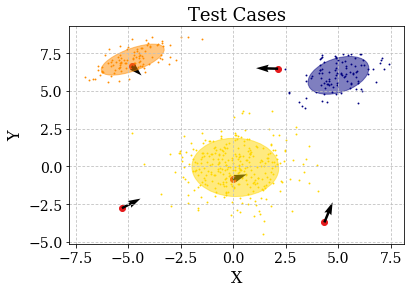

In [12]:
plot_results(obser, gmm.predict(obser), gmm.means_, gmm.covariances_, 
             'Test Cases')
plt.scatter(*np.split(states, 2, axis=1))
plt.quiver(states.T[0], states.T[1], actions.T[0], actions.T[1])

## 3. Compute multivariate normal CDFs

Use Alan Genz/Enthought, Inc.'s multivariate normal CDF Fortran functions in Scipy. Here is a [blog post](http://www.nhsilbert.net/source/2014/04/multivariate-normal-cdf-values-in-python/) on the functions. And [here](https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/mvndst.f) is the Fortran code.

I will need to optimize this if I plan to use it online.

In [13]:
from scipy.stats import mvn
import scipy.stats as stats

In [75]:
action_likelihoods = np.zeros((5, 3))
dim = 2
indicator = np.zeros((5, 3))

# This needs to be optimized before going online
for i in xrange(5):
    for g in xrange(3):
        low = np.zeros((dim))
        upp = np.zeros((dim))
        for j in xrange(dim):
            if actions[i, j] < 0:
                low[j] = gmm.means_[g, j] - 10 * gmm.covariances_[g, j, j]
                upp[j] = states[i, j]
            elif actions[i, j] > 0:
                low[j] = states[i, j]
                upp[j] = gmm.means_[g, j] + 10 * gmm.covariances_[g, j, j]
            else:  # Yields probability 1
                low[j] = gmm.means_[g, j] - 10 * gmm.covariances_[g, j, j]
                upp[j] = gmm.means_[g, j] + 10 * gmm.covariances_[g, j, j]
        action_likelihoods[i, g], indicator[i, g] = mvn.mvnun(low, upp, gmm.means_[g], gmm.covariances_[g])

states, actions, action_likelihoods, indicator

(array([[ 4.34113029, -3.70947271],
        [ 2.13837176,  6.48325436],
        [-0.0238878 , -0.85284696],
        [-4.83099416,  6.64742997],
        [-5.29422661, -2.7632426 ]]), array([[ 0.37071964,  0.90678669],
        [-0.99210347,  0.02438453],
        [ 0.62524192,  0.22505213],
        [ 0.44351063, -0.41624786],
        [ 0.83554825,  0.42915157]]), array([[  1.85560189e-03,   3.86352677e-18,   7.42849556e-01],
        [  7.84308567e-07,   7.96099376e-01,   1.01885780e-04],
        [  3.81800562e-01,   3.62058343e-06,   9.99999555e-01],
        [  9.99631084e-01,   5.00330272e-02,   7.52895063e-01],
        [  9.75918437e-01,   6.85080541e-01,   1.00000000e+00]]), array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]))

In [76]:
def plot_action_likelihoods(action_likelihoods):
    index = np.arange(action_likelihoods.shape[0])
    bar_width = 0.2

    opacity = 0.4
#     error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, action_likelihoods[:, 0], bar_width,
                     alpha=opacity,
                     color='b',
                     label='Subgoal 0')

    rects2 = plt.bar(index + bar_width, action_likelihoods[:, 1], bar_width,
                     alpha=opacity,
                     color='r',
                     label='Subgoal 1')
    
    rects3 = plt.bar(index + 2 * bar_width, action_likelihoods[:, 2], bar_width,
                     alpha=opacity,
                     color='g',
                     label='Subgoal 2')

    plt.xlabel('State')
    plt.ylabel('Likelihood')
    plt.title('State Likelihoods')
    plt.xticks(index + bar_width / 2, ('0', '1', '2', '3', '4'))
    plt.legend()

    plt.tight_layout()
    plt.show()

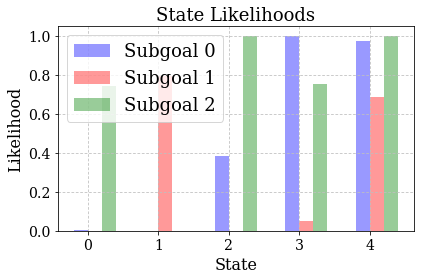

In [77]:
plot_action_likelihoods(action_likelihoods)

## 4. Test Case

Testing to see in the case where covariance is diagonal, if the multivariate cdf reduces to the product of univariate pdfs.

In [78]:
new_means = [5, 6]
new_cov = [[1, 0], [0, 2]]

# Set our bounds for the mvnun algo
low = [-100, -200]
upp = [7, 7]

genz_cdf, _ = mvn.mvnun(low, upp, new_means, new_cov)
uni_cdf_x = stats.norm(loc=new_means[0], scale=new_cov[0][0]).cdf(upp[0])
uni_cdf_y = stats.norm(loc=new_means[1], scale=new_cov[1][1]).cdf(upp[1])

print(genz_cdf, uni_cdf_x * uni_cdf_y)

(0.7429541524828047, 0.67573159904281654)


In [79]:
# Convenience functions
def plot_normal_ellipse(mean, covar, ax):
    ax.scatter(*mean)
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='gold')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

In [80]:
def plot_state_action(state, action):
    plt.scatter(*state)
    plt.quiver(*(state + action), scale=5)

In [81]:
# Function for integrating multivariate normal approach
def action_likelihoods(states, actions, means, covs):
    # Warning: if only one state, or only one subgoal, may need to add extra axis
    action_likelihoods = np.zeros((states.shape[0], means.shape[0]))
    indicator = np.zeros(action_likelihoods.shape)
    for i in xrange(states.shape[0]):
        for g in xrange(means.shape[0]):
            low = np.zeros(states.shape[1])
            upp = np.copy(low)
            for j in xrange(states.shape[1]):
                if actions[i, j] < 0:
                    low[j] = means[g, j] - 10 * covs[g, j, j]
                    upp[j] = states[i, j]
                elif actions[i, j] > 0:
                    low[j] = states[i, j]
                    upp[j] = means[g, j] + 10 * covs[g, j, j]
                else:  # Yields probability 1
                    low[j] = means[g, j] - 10 * covs[g, j, j]
                    upp[j] = means[g, j] + 10 * covs[g, j, j]
            action_likelihoods[i, g], indicator[i, g] = mvn.mvnun(low, upp, means[g], covs[g])
    return action_likelihoods, indicator

### Different take: Marginalizing out variables with no action

Because we have multivariate Gaussian, marginalizing out a variable should be as simple as dropping the mean and covariance elements.

In [82]:
new_means = [5, 5]
new_cov = [[1, 0.5], [0.3, 1.5]]

state = [2, 3]
a1 = [1, 0]
a2 = [0, 1]

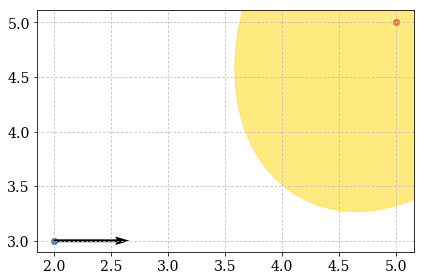

In [83]:
plt.figure()
ax = plt.gca()
plot_normal_ellipse(new_means, new_cov, ax)
plot_state_action(state, a1)
plt.tight_layout()

In [93]:
# Gotta fix the data for the algo
if type(new_means) == list:
    for elem in ['new_means', 'new_cov', 'state', 'a1', 'a2']:
        globals()[elem] = np.expand_dims(globals()[elem], axis=0)
new_means

1.0

In [88]:
ll, i = action_likelihoods(state, a1, new_means, new_cov)
print('Joint probability: %.4f' % ll[0, 0])

Joint probability: 0.9987


In [96]:
marginal_ll = 1 - stats.norm(loc=new_means[0, 0], scale=new_cov[0, 0, 0]).cdf(state[0, 0])
print('Marginal probability: %.4f' % marginal_ll)

Marginal probability: 0.9987


# SWEET!

Let's start over.

Our goal is to define the probability that a particular action from a particular state seeks subgoal gz, which belongs to a gaussian multivariate distribution.

This can be achieved in the multivariate Gaussian case by integrating the multivariate probability density function over a custom domain, which we define as the action-targeted-states (ATS) domain, denoted $\mathcal{D}$. The domain is defined in the actuator state-space coordinates $\mathcal{D} \subset \mathbb{R}^m$.

In axes in which the action is zero, the domain is infinite (corresponding to marginalizing out those variabeles, more on that later).

$$\mathcal{D} = \bigcap_{j} \{d: d = s + w (a \cdot \hat{u}_j) + v, \hat{u}_j \cdot v = 0, w > 0\}$$

Where $\hat{u}_j$ is a unit vector in the $j^{th}$ input direction.
In words, $\mathcal{D}$ is the intersection of the sets formed by linear combinations of the positively scaled action with all perpendicular  actions.

Then our action likelihood is

$$\Pr(\mathbf{a}_i | \mathbf{s}_i, \mathbf{g}_z) = \int ... \int_\mathcal{D} f_z(x_1, x_2, ..., x_m) \ dx_1 ... dx_m $$

where $f_z(x_1, x_2, ..., x_m)$ is the probability density function of subgoal $g_z$

This integration can be computed by Alan Genz's multivariate normal functions in scipy. However, in most cases the action will only be along one or two unit vector directions, such that for the other directions $a \cdot \hat{u}_j = 0$ in this case, the domain in the $j^{th}$ direction is infinite. Computing this integral simply corresponds to marginalizing out the $j^{th}$ variable. But with multivariate normal distributions we can simply drop the covariances from the covariance matrix and compute over the remaining variables.


I'll end the notebook here with the goal of porting these functions to the simulation. 